In [112]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from midiutil import MIDIFile 

# data path definition
toolik_data = pathlib.Path('../data/Toolik-met')

# Load and prepare climate data

In [159]:
# load the data
data = pd.read_csv(pathlib.Path(toolik_data, '1-hour_data.csv'))

# create datetime column
data['datetime'] = pd.to_datetime(data.date) + pd.to_timedelta(data.hour/100, unit = 'h')

# drop date and hour columns
data = data.drop(labels=['date', 'hour'], axis=1)

# drop non-unique datetime rows
data = data.drop_duplicates(subset=['datetime'])

# drop rows with NA datetime
data = data.dropna(subset=['datetime'])

# set index
data = data.set_index('datetime')

# resample to series to regular hourly interval
data = data.resample('D').interpolate(method='time')

data = data[['air_temp_1m', 'pyranometer']]
data

,air_temp_1m,pyranometer
datetime,,
1988-06-10,NaN,NaN
1988-06-11,13.8,0.028
1988-06-12,10.4,0.020
1988-06-13,4.8,0.005
1988-06-14,8.1,0.023
...,...,...
2021-12-27,-0.3,0.000
2021-12-28,-0.3,0.000
2021-12-29,-0.3,0.000


# Temporally subset the data

In [166]:
# subset a single year of data
YR = 2005
end_date = str(YR+1) + "-06-01 12:00"
start_date = str(YR) + "-06-01 12:00"

data_sub = data.loc[start_date:end_date]

# Process data for temperature track

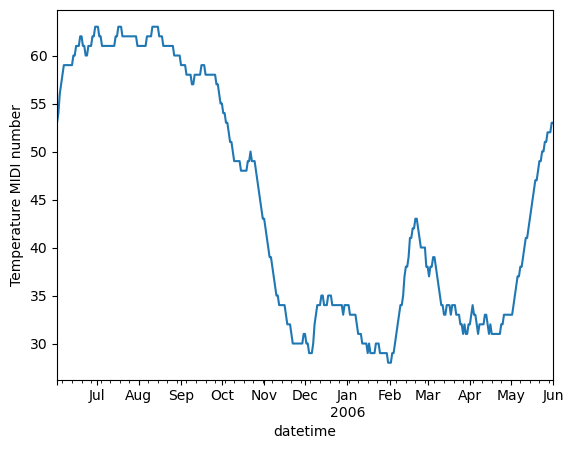

In [196]:
# isolate temperature data for one track
temp = data_sub['air_temp_1m']

# rescale between specified bounds, convert to integer
interval_max = 70
interval_min = 20
temp_rescale = (temp-temp.min())/(temp.max()-temp.min()) * (interval_max - interval_min) + interval_min
temp_rescale = temp_rescale.astype(int)

# Exponential weighed mean smooth
temp_smooth = temp_rescale.ewm(span = 30).mean().astype(int)

temp_smooth.plot(ylabel = "Temperature MIDI number")
plt.show()

# Process data for raditation track

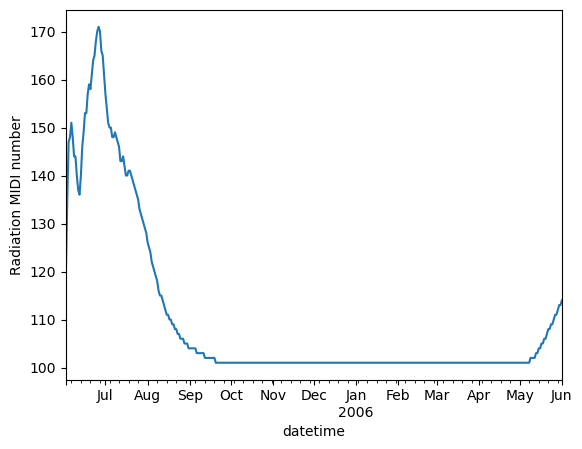

In [197]:
rad = data_sub['pyranometer']

# rescale between specified bounds, convert to integer
interval_max = 200
interval_min = 100
rad_rescale = (rad-rad.min())/(rad.max()-rad.min()) * (interval_max - interval_min) + interval_min
rad_rescale = rad_rescale.astype(int)

# Exponential weighed mean smooth
rad_smooth = rad_rescale.ewm(span = 30).mean().astype(int)

rad_smooth.plot(ylabel = "Radiation MIDI number")
plt.show()

# Build and write MIDI file

In [192]:
# instantiate MIDI file
MyMIDI  = MIDIFile(numTracks=2, file_format=1)

# ***************************************
# TEMPERATURE track
track    = 0
channel  = 0
time     = 0    # In beats
duration = 1    # In beats
tempo    = 600   # In BPM
volume   = 100  # 0-127, as per the MIDI standard
program = 53

for i, pitch in enumerate(temp_smooth):
    MyMIDI.addNote(track, channel, pitch, time + i, duration, volume)
MyMIDI.addProgramChange(track, channel, time, program)
MyMIDI.addTempo(track, time, tempo)

# ***************************************
# RADIATION track
track    = 1
channel  = 2
time     = 0    # In beats
duration = 1    # In beats
tempo    = 600   # In BPM
volume   = 50  # 0-127, as per the MIDI standard
program = 24

for i, pitch in enumerate(rad_smooth):
    MyMIDI.addNote(track, channel, pitch, time + i, duration, volume)
MyMIDI.addProgramChange(track, channel, time, program)
MyMIDI.addTempo(track, time, tempo)

# ***************************************
# write midi file
with open("noise.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)